# Forecasting with Systems  
**Example:** log gas rigs, log gas price, log oil price (monthly)

**We will:**
1. Diagnose (non)stationarity using ADF tests and discuss spurious regression.  
2. Estimate a vector autoregression (VAR) after deciding whether or not to use levels or differenced data.
3. Generate a forecast using the resulrs of the VAR



In [7]:
#import warnings
#warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR

# --- Load data ---
path = "gas_oil_rig_price_jul2025.csv"
df = pd.read_csv(path)

# --- Use month_no as the analysis index ---
if "month_no" not in df.columns:
    raise ValueError("Expected a 'month_no' column in the CSV.")
df = df.sort_values("month_no").drop_duplicates(subset=["month_no"]).set_index("month_no")

# --- Select the three logged series ---
cols = ["lngasrigs", "lngasprice", "lnoilprice"]
missing = [c for c in cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing expected columns: {missing}")

Y = (
    df[cols]
    .apply(pd.to_numeric, errors="coerce")
    .replace([np.inf, -np.inf], np.nan)
    .dropna()
    .copy()
)

print("Data sample:")
display(Y.head())
print("Rows:", len(Y), "| Index monotonic:", Y.index.is_monotonic_increasing)

# --- Simple monthly DatetimeIndex for plotting (start = Jan 1994) ---
months_levels = pd.date_range("1994-01-01", periods=len(Y), freq="MS")

# Create plotting copy with real months on the x-axis (keep Y for analysis)
Y_plot = Y.copy()
Y_plot.index = months_levels



Data sample:


,lngasrigs,lngasprice,lnoilprice
month_no,,,
1,6.052089,0.853138,2.709383
2,6.003887,0.856541,2.693275
3,5.998937,0.746214,2.684440
4,5.986452,0.747162,2.793004
5,5.945421,0.663203,2.880882


Rows: 364 | Index monotonic: True


## Visualizing the four log series

We begin with a simple plot of the logged variables:

$$
\{\ln(\text{gas rigs}),\;  \ln(\text{gas price}),\; \ln(\text{oil price})\}.
$$


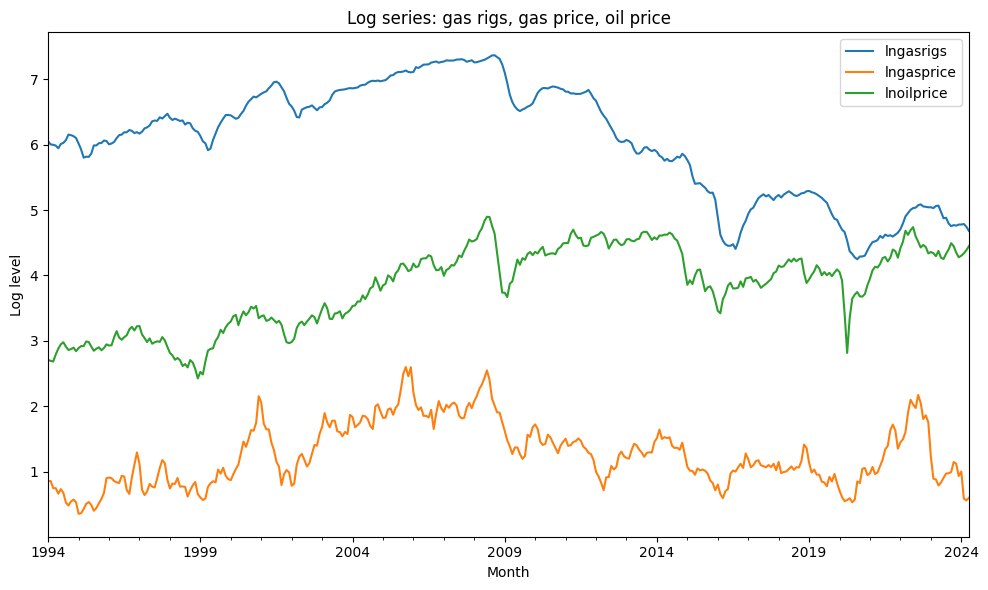

In [8]:
# --- Plot the log series with real months on x-axis ---
ax = Y_plot.plot(figsize=(10, 6))
ax.set_title("Log series: gas rigs, gas price, oil price")
ax.set_xlabel("Month")
ax.set_ylabel("Log level")
plt.tight_layout()
plt.show()

## Stationarity, Spurious Regression, and the ADF Test

A weakly stationary process satisfies  
$$
\mathbb{E}[y_t]=\mu,\quad \mathrm{Var}(y_t)=\sigma^2,\quad
\mathrm{Cov}(y_t,y_{t-k})=\gamma_k.
$$

Many macro/commodity series follow a unit-root process  
$$
y_t = \rho y_{t-1} + \varepsilon_t.
$$
If $\rho=1$, the series is integrated of order 1, $I(1)$, meaning  
$$
y_t \sim I(1) \quad \Longleftrightarrow \quad \Delta y_t \text{ is stationary.}
$$

**Augmented Dickey–Fuller (ADF) test.** We estimate  
$$
\Delta y_t = \alpha + \delta\, y_{t-1} + \sum_{i=1}^{p}\phi_i \Delta y_{t-i} + \varepsilon_t,
$$
and test $H_0:\delta=0$ (unit root) vs. $H_1:\delta<0$ (stationary).  
Here we use the constant-only version (no trend), suitable for many logged economic variables.




In [9]:
def adf_summary(series, name, maxlag=12):
    res = adfuller(series.dropna(), regression="c", autolag="AIC", maxlag=maxlag)
    return {
        "series": name,
        "ADF stat": res[0],
        "p-value": res[1],
        "used lag": res[2],
        "nobs": res[3],
        "cv 1%": res[4]["1%"],
        "cv 5%": res[4]["5%"],
        "cv 10%": res[4]["10%"],
    }

adf_levels  = pd.DataFrame([adf_summary(Y[c], c) for c in Y.columns])
adf_diffs   = pd.DataFrame([adf_summary(Y[c].diff(), f"D({c})") for c in Y.columns])

print("ADF (levels) — constant, no trend")
display(adf_levels.round(4))

print("\nADF (first differences) — constant, no trend")
display(adf_diffs.round(4))



ADF (levels) — constant, no trend


,series,ADF stat,p-value,used lag,nobs,cv 1%,cv 5%,cv 10%
0,lngasrigs,-0.6037,0.8701,4,359,-3.4487,-2.8696,-2.5711
1,lngasprice,-2.6320,0.0866,12,351,-3.4491,-2.8698,-2.5712
2,lnoilprice,-2.1333,0.2313,2,361,-3.4486,-2.8696,-2.5711



ADF (first differences) — constant, no trend


,series,ADF stat,p-value,used lag,nobs,cv 1%,cv 5%,cv 10%
0,D(lngasrigs),-7.2521,0.0,3,359,-3.4487,-2.8696,-2.5711
1,D(lngasprice),-6.1960,0.0,11,351,-3.4491,-2.8698,-2.5712
2,D(lnoilprice),-12.8802,0.0,1,361,-3.4486,-2.8696,-2.5711


## Interpreting the ADF Output

- **Null hypothesis:** the series has a unit root (nonstationary).  
- **Decision rule:** if the test statistic is *less than* the critical value (in absolute terms, more negative) **or** the p-value < 0.05, reject the null.

**Reading the tables above:**
- If a variable in levels has p-value > 0.05 (and the ADF stat is not more negative than the 5% critical value), we fail to reject a unit root ⇒ treat it as $I(1)$.
- If its first difference has p-value < 0.05 (ADF stat more negative than the 5% critical), we reject a unit root in the differenced series ⇒ $\Delta y_t$ is stationary, consistent with $y_t \sim I(1)$.

**Deterministic specification note:** Here we used a constant/no-trend ADF. If your plots show clear deterministic trends, re-run with a trend; otherwise you risk over-rejecting or under-rejecting unit roots.


## Vector Autoregression

A $k$-variable VAR($p$) in levels is

$$
y_t = A_1 y_{t-1} + A_2 y_{t-2} + \cdots + A_p y_{t-p} + u_t, \qquad u_t \sim (0,\Sigma_k).
$$

Each element of $y_t$ depends on its own past and the past of all other variables.  

The number of lags $p$ is typically chosen by information criteria (AIC, BIC, HQIC).

Each $A_i$ is a $k\times k$ matrix of coefficients describing how each variable responds to the $i$-th lag of all variables.  

For example, the first-lag coefficient matrix for a three-variable VAR is:

$$
A_1 =
\begin{bmatrix}
a_{11}^{(1)} & a_{12}^{(1)} & a_{13}^{(1)} \\
a_{21}^{(1)} & a_{22}^{(1)} & a_{23}^{(1)} \\
a_{31}^{(1)} & a_{32}^{(1)} & a_{33}^{(1)}
\end{bmatrix}.
$$

If the variables are $I(1)$ and not cointegrated, differencing before estimation is appropriate.  

If they are $I(1)$ and cointegrated, the correct specification is a vector error correction model (VECM). We will cover VECM in the next lecture.

### Our three-variable system

$$
y_t =
\begin{bmatrix}
\ln(\text{gas rigs}_t) \\
\ln(\text{gas price}_t) \\
\ln(\text{oil price}_t)
\end{bmatrix}.
$$

A VAR($p$) for this system is:


$$
\begin{aligned}
\ln(\text{gas rigs}_t)
&= a_{11}^{(1)}\,\ln(\text{gas rigs}_{t-1})
+ a_{12}^{(1)}\,\ln(\text{gas price}_{t-1})
+ a_{13}^{(1)}\,\ln(\text{oil price}_{t-1})
+ \cdots + u_{1t}, \\
\ln(\text{gas price}_t)
&= a_{21}^{(1)}\,\ln(\text{gas rigs}_{t-1})
+ a_{22}^{(1)}\,\ln(\text{gas price}_{t-1})
+ a_{23}^{(1)}\,\ln(\text{oil price}_{t-1})
+ \cdots + u_{2t}, \\
\ln(\text{oil price}_t)
&= a_{31}^{(1)}\,\ln(\text{gas rigs}_{t-1})
+ a_{32}^{(1)}\,\ln(\text{gas price}_{t-1})
+ a_{33}^{(1)}\,\ln(\text{oil price}_{t-1})
+ \cdots + u_{3t}.
\end{aligned}
$$

$$
\Sigma_k =
\begin{bmatrix}
\mathrm{Var}(u_{1t}) & \mathrm{Cov}(u_{1t}, u_{2t}) & \mathrm{Cov}(u_{1t}, u_{3t}) \\
\mathrm{Cov}(u_{2t}, u_{1t}) & \mathrm{Var}(u_{2t}) & \mathrm{Cov}(u_{2t}, u_{3t}) \\
\mathrm{Cov}(u_{3t}, u_{1t}) & \mathrm{Cov}(u_{3t}, u_{2t}) & \mathrm{Var}(u_{3t})
\end{bmatrix}.
$$



## VAR in First Differences

The ADF tests show that $\ln(\text{gas rigs})$, $\ln(\text{gas price})$, and $\ln(\text{oil price})$
are nonstationary in levels but stationary in first differences.  

Because we have not yet tested for cointegration, we will **assume no cointegration** for now.  
In that case, the appropriate specification is a VAR in **first differences** rather than levels.

We simply difference each variable before estimating the model:

$$
\Delta y_t = B_1 \Delta y_{t-1} + B_2 \Delta y_{t-2} + \cdots + B_{p-1} \Delta y_{t-p+1} + \varepsilon_t,
$$

where $B_i$ are $3 \times 3$ matrices of coefficients describing how changes in each variable respond to past changes in all variables.

For our system, the differenced version looks like:

$$
\begin{aligned}
\Delta \ln(\text{gas rigs}_t)
&= b_{11}^{(1)} \Delta \ln(\text{gas rigs}_{t-1})
+ b_{12}^{(1)} \Delta \ln(\text{gas price}_{t-1})
+ b_{13}^{(1)} \Delta \ln(\text{oil price}_{t-1})
+ \cdots + \varepsilon_{1t}, \\
\Delta \ln(\text{gas price}_t)
&= b_{21}^{(1)} \Delta \ln(\text{gas rigs}_{t-1})
+ b_{22}^{(1)} \Delta \ln(\text{gas price}_{t-1})
+ b_{23}^{(1)} \Delta \ln(\text{oil price}_{t-1})
+ \cdots + \varepsilon_{2t}, \\
\Delta \ln(\text{oil price}_t)
&= b_{31}^{(1)} \Delta \ln(\text{gas rigs}_{t-1})
+ b_{32}^{(1)} \Delta \ln(\text{gas price}_{t-1})
+ b_{33}^{(1)} \Delta \ln(\text{oil price}_{t-1})
+ \cdots + \varepsilon_{3t}.
\end{aligned}
$$

This model captures short-run dynamics — how changes in one variable relate to recent changes in others —  
but it omits any long-run equilibrium that might exist (which we will handle later with cointegration and the VECM).


In [10]:
# 1) Difference the data
Y_diff = Y.diff().dropna()

# 2) Monthly index for differences (one shorter than Y)
months_diff = months_levels[1:]

# 3) Lag selection and estimation
var_diff = VAR(Y_diff)
sel_diff = var_diff.select_order(maxlags=13)
print("Lag selection (differenced data):", sel_diff.selected_orders)

p_diff = sel_diff.selected_orders.get("bic")
if p_diff is None:
    candidates = [v for v in sel_diff.selected_orders.values() if v is not None]
    p_diff = min(candidates) if candidates else 2
print(f"\nEstimating VAR in first differences with p = {p_diff}")

var_res_diff = var_diff.fit(p_diff)
print("Stable (all roots inside unit circle)?", var_res_diff.is_stable())
print(var_res_diff.summary())



/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Lag selection (differenced data): {'aic': np.int64(4), 'bic': np.int64(1), 'hqic': np.int64(2), 'fpe': np.int64(4)}

Estimating VAR in first differences with p = 1
Stable (all roots inside unit circle)? True
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 03, Nov, 2025
Time:                     12:40:59
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -15.2195
Nobs:                     362.000    HQIC:                  -15.2973
Log likelihood:           1249.12    FPE:                2.15882e-07
AIC:                     -15.3485    Det(Omega_mle):     2.08881e-07
--------------------------------------------------------------------
Results for equation lngasrigs
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const     

## Residuals from the Differenced VAR
We compute residuals and plot them.



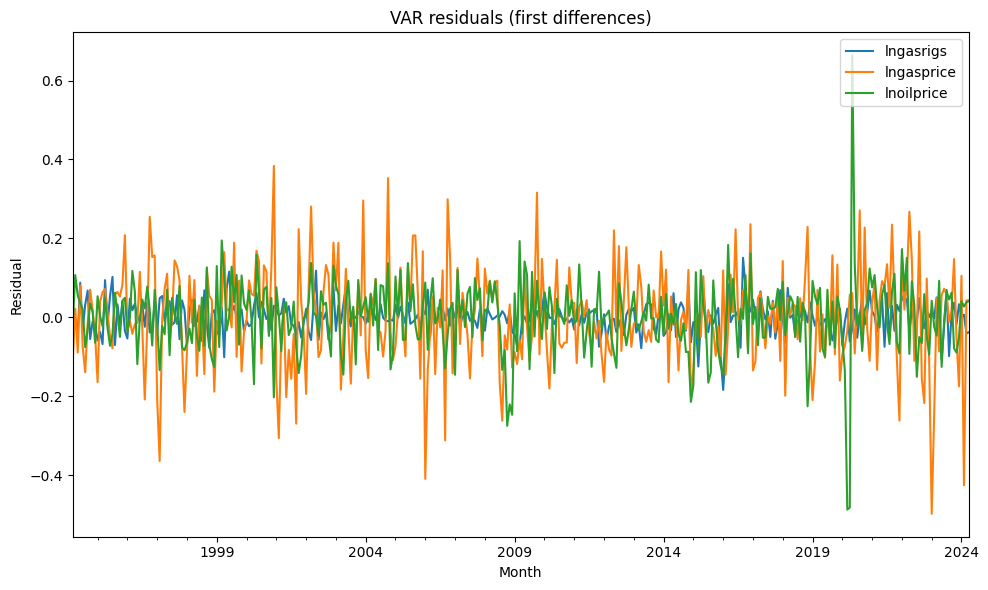

In [11]:
# Fitted values align with Y_diff.iloc[p_diff:]
fitted = var_res_diff.fittedvalues
actual = Y_diff.iloc[p_diff:]                 # align to fitted
resid_diff = actual - fitted

# Month axis for residuals (skip first p_diff months of differences)
resid_months = months_diff[p_diff:]
assert len(resid_months) == resid_diff.shape[0], (len(resid_months), resid_diff.shape[0])

resid_diff_plot = resid_diff.copy()
resid_diff_plot.index = resid_months

# Plot residuals with calendar month x-axis
ax = resid_diff_plot.plot(figsize=(10, 6))
ax.set_title("VAR residuals (first differences)")
ax.set_xlabel("Month")
ax.set_ylabel("Residual")
ax.legend(loc="upper right")
plt.tight_layout()
plt.show()




## Forecasting from the Differenced VAR

Our dataset spans **January 1994 – April 2024**.  
We now use the fitted VAR in first differences to produce a **12-month forecast** beginning **May 2024 – April 2025**.

The VAR predicts future *changes* ($\widehat{\Delta y}_{T+h}$).  
To obtain **log-level forecasts**, we add these cumulative predicted changes to the last observed logs:

$$
\widehat{y}_{T+h} = y_T + \sum_{j=1}^{h}\widehat{\Delta y}_{T+j}.
$$

Because our variables are natural logs, exponentiating converts forecasts back to **actual levels** (e.g., number of rigs or prices).  

The plot below:
- shows **actual data** (solid) through April 2024,  
- extends **forecasts** (dashed) for the next 12 months,  
- marks the forecast start (May 2024) with a vertical line and shaded region.




History window: Jan 2024 → Apr 2024
Forecast window: May 2024 → Jan 2025


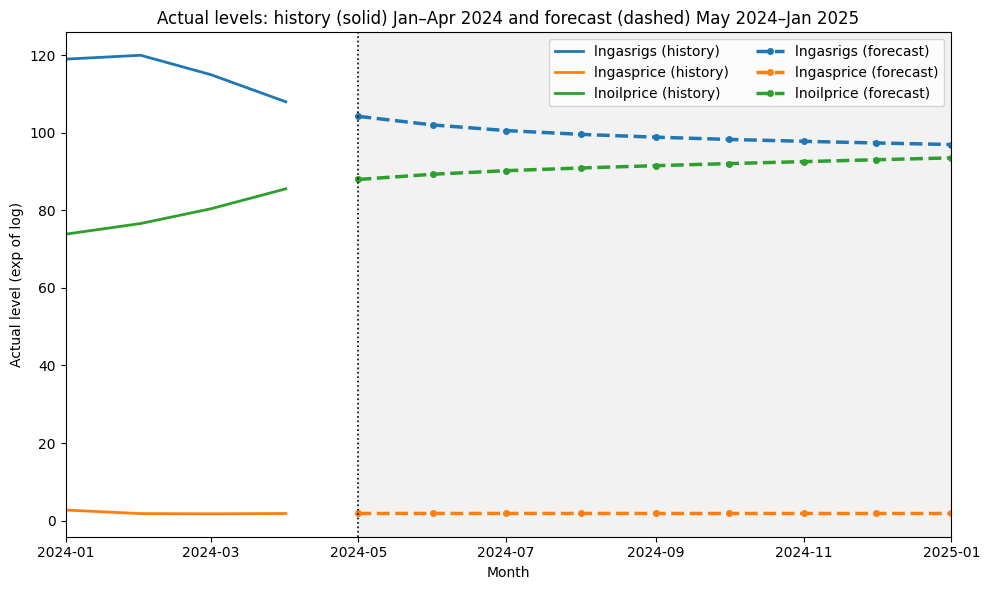

In [12]:
# Windows
window_start = pd.Timestamp("2024-01-01")
target_end   = pd.Timestamp("2025-01-01")  # inclusive x-limit for the plot

# Last observed month (from your levels date index)
last_obs = months_levels[-1]  # should be 2024-04-01

# Compute how many months to forecast so we reach Jan 2025
h = (target_end.year - last_obs.year) * 12 + (target_end.month - last_obs.month)
if h <= 0:
    raise ValueError("Forecast horizon computed as non-positive; check months_levels[-1].")

# Prepare last p lags for the VAR in differences
p_diff = var_res_diff.k_ar
y0 = var_res_diff.endog[-p_diff:]

# Forecast Δ logs
fc_diff_arr = var_res_diff.forecast(y=y0, steps=h)
fc_diff = pd.DataFrame(fc_diff_arr, columns=Y_diff.columns)

# Forecast months: start the month after the last observed
fc_months = pd.date_range(last_obs + pd.offsets.MonthBegin(1), periods=h, freq="MS")
fc_diff.index = fc_months

# Reconstruct log-level forecasts (cumulate Δ from last observed log level)
last_level = Y.iloc[-1].copy()
fc_levels_arr = last_level.values + np.cumsum(fc_diff_arr, axis=0)
fc_levels = pd.DataFrame(fc_levels_arr, columns=Y.columns, index=fc_months)

# Convert to actual (exp of logs)
Y_actual = np.exp(Y.copy()); Y_actual.index = months_levels
fc_actual = np.exp(fc_levels)

# Slice history and forecast to the requested window
hist = Y_actual.loc[window_start:last_obs]      # Jan–Apr 2024
fcast = fc_actual.loc[window_start:target_end]  # May 2024–Jan 2025

# Diagnostics so you can confirm the spans
print("History window:", hist.index.min().strftime("%b %Y"), "→", hist.index.max().strftime("%b %Y"))
print("Forecast window:", fcast.index.min().strftime("%b %Y"), "→", fcast.index.max().strftime("%b %Y"))

# Consistent colors by series
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
series = list(Y.columns)
color_map = {series[i]: colors[i % len(colors)] for i in range(len(series))}

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

# History (solid)
for col in series:
    ax.plot(hist.index, hist[col], color=color_map[col], linewidth=2, label=f"{col} (history)")

# Forecast (dashed with markers)
for col in series:
    if col in fcast:
        ax.plot(fcast.index, fcast[col], color=color_map[col], linestyle="--", linewidth=2.5,
                marker="o", markersize=4, label=f"{col} (forecast)")

# Forecast boundary and shading
forecast_start = last_obs + pd.offsets.MonthBegin(1)  # May 2024
ax.axvline(forecast_start, color="k", linestyle=":", linewidth=1.2, zorder=5)
ax.axvspan(forecast_start, target_end, color="0.9", alpha=0.5, zorder=0)

# Harmonize x-axis to the requested window
ax.set_xlim(window_start, target_end)

ax.set_title("Actual levels: history (solid) Jan–Apr 2024 and forecast (dashed) May 2024–Jan 2025")
ax.set_xlabel("Month")
ax.set_ylabel("Actual level (exp of log)")
ax.legend(loc="best", ncol=2)
plt.tight_layout()
plt.show()



